# Power Splitter Demo

This is an introductory demo for using angler for inverse design.   

Here we will walk through designing a 50-50 power splitter.

## Setup

We'll first import all of the packages we need and set up our notebook.

In [17]:
import numpy as np
import matplotlib.pylab as plt
import copy

# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now let's define some of the parameters we'll be using in our optimization

In [18]:
# define the similation constants
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-9           # amplitude of modal source (make around 1 for nonlinear effects)

In [19]:
# define material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity

In [20]:
# geometric parameters for a 1 -> 2 port device
L = 6         # length of box (L0)
H = 4         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5     # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

## Defining the Simulation Object
Now, we can create an initial relative permittivity, define our design region, and create the `Simulation` object for our domain.

Computed a domain with 200 grids in x and 140 grids in y
The simulation has 20 grids per free space wavelength


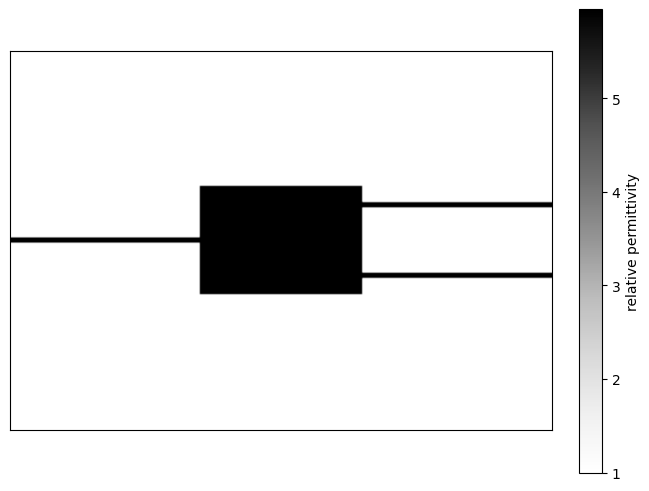

In [21]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))

# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

`Simulation` objects are used for running the actual FDFD simulations and we define our optimizations over them.

## Sources and Probes

With our simulation defined, we may now define the modal profiles of our input and output ports.  

We will first add a modal source to our simulation corresponding to the port on the left.

Then, we'll create two temporary simulations that are identical to the original, add modal sources for the top and bottom ports, and use these to get numpy arrays corresponding to the top and bottom probes of the device.  While in the code we are labelling these `J_top` and `J_bot`, in the paper, these are called $\mathbf{m}_{t}$ and $\mathbf{m}_b$ respectively

In [22]:
# set the input waveguide modal source
simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# make a new simulation to get the modal profile of the top output port
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# make a new simulation to get the modal profile of the bottom output port
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

Now we can use `J_top` and `J_bot` as probes in our objective function.  We'll no longer need the `top` and `bot` Simulations.

We can plot solve the simulation for the electric and magnetic fields and then plot the results.

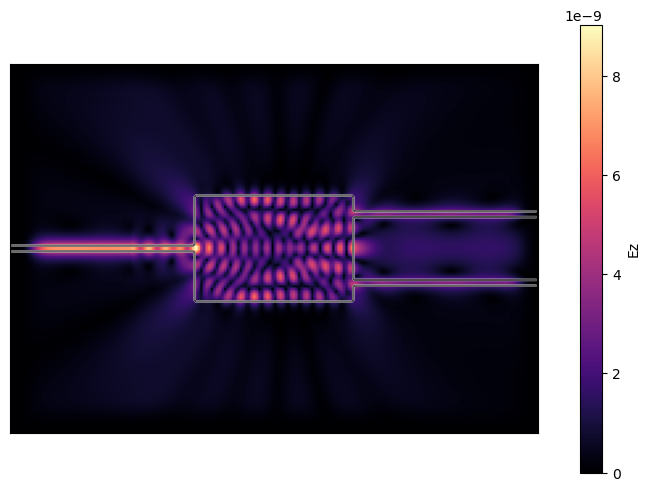

In [23]:
# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

## Normalizing

As an optional step, we'll normalize the modal amplitudes such that $|J^T E|^2 = 1$ for perfect transmission to the port corresponding to $J$.

To do this, we'll make another temporary simulation with just a straight waveguide of the same source as our original three port.

We'll then compute $|J^T E|^2$ for the output port, and normalize `J_in` and `J_out` using this. 

computed a scale of 2.7336059102792795e-17


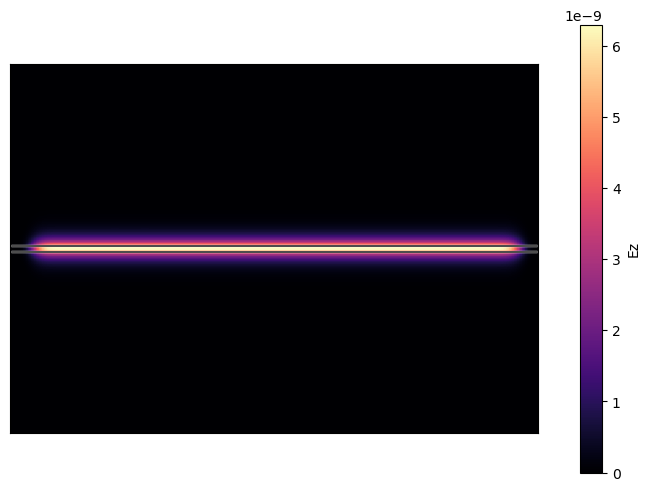

In [24]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg*J_out)))
J_out = J_out
print('computed a scale of {}'.format(SCALE))

simulation_wg.plt_abs(outline=True, cbar=True);

J_top = J_top / np.sqrt(SCALE)
J_bot = J_bot / np.sqrt(SCALE)

## Changing the design region

Optionally, we can also change the design region to several different styles before optimization.  

Here we'll use `random_sym` which randomly assigns each pixel within the design region betwee 1 and the maximum permittivity.  

This is mirrored across y=0.

Making it symmetric leads to more symmetric final devices.

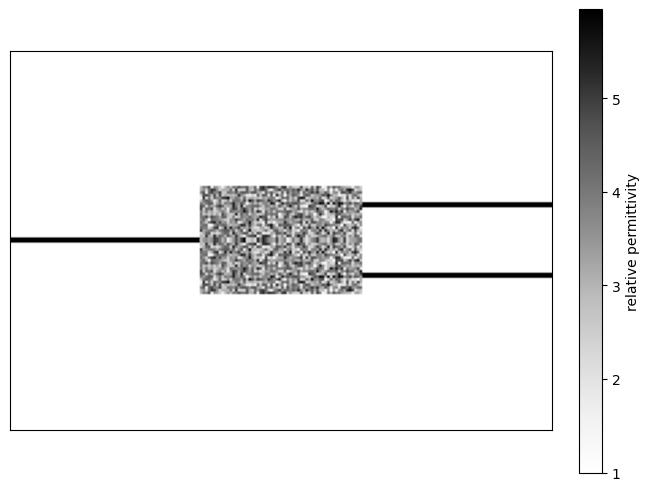

In [25]:
# changes design region. 'style' can be one of {'full', 'empty', 'halfway', 'random', 'random_sym'}.
simulation.init_design_region(design_region, eps_m, style='random_sym')
simulation.plt_eps(outline=False)
plt.show()

## Defining Objective Functions

Now is one of the most important steps: defining the objective function for optimization / inverse design.

To do this, we define a function `J` which takes in the linear fields as the first argument and the nonlinear fields as a second argument.

Until we make this more flexible, if your problem is linear, you still need the nonlinear fields argument, but you dont have to use it within the body of the function. 

We require that you define your numpy operations within J using the autograd wrapper for numpy.

This allows us to automatically compute the partial derivatives of $J$ w.r.t. $E$ and $E_{nl}$, which are used in the adjoint.  

This is super helpful when you define complicated objective functions and dont feel like computing these by hand!

Below is an example of an objective function where the top and bottom port transmissions are directly multiplied.

`angler` will try to maximize `J` w.r.t the permittivity in the design region.  Since we're multiplying the transmissions here, a highest possible value of `J = 1` will occur when each port is at 50% transmission, which is what we want.

In [26]:
# define objective function  (equal power transmission to bottom and top)
import autograd.numpy as npa
from angler.objective import Objective, obj_arg

arg1 = obj_arg('ez', component='Ez', nl=False)

def J(ez):
    linear_top =     1*npa.sum(npa.square(npa.abs(ez*J_top)))
    linear_bot =     1*npa.sum(npa.square(npa.abs(ez*J_bot)))
    objfn = linear_top * linear_bot * 4
    return objfn

objective = Objective(J, arg_list=[arg1])

## Defining the Optimization

Now we are ready to define the `Optimization`, which will perform the inverse design on top of our `simulation`.  

We give the optimization our objective function, simulation object, design region, and specify the maximum permittivity to allow.

Also, we pass in some optional arguments that define the filtering and projection that are used to create smooth feature sizes.

`R` controls the minimum feature size.  
`beta` controls how strongly to bias the permittivitiy to be either air or material.

See the supplementary information of our paper (coming soon) for more details.

The `Optimization` object takes a little bit of time to initialize because we need to set up the spatial filter.

In [27]:
# make optimization object
R = 4          # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300     # projection strength
eta= 0.50      # projection halfway

optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

  0% (0 of 151) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (2 of 151) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  2% (4 of 151) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05
  3% (6 of 151) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05
  5% (8 of 151) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:05
  6% (10 of 151) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  7% (12 of 151) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  9% (14 of 151) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 10% (16 of 151) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04
 11% (18 of 151) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04
 13% (20 of 151) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04
 14% (22 of 151) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04
 16% (25 of 151) |###                   

## Checking Adjoint Derivatives

We allow users to check that their adjoint derivatives match finite difference numerical derivatives.

This is good practice to make sure things are working correctly

In [28]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [0.00013030747346181882, 2.750960299181004e-05, 3.045163082534567e-07, 2.0698471757721203e-05, -5.288764887599612e-06]
numerical gradient = [0.00013002919241789264, 2.7432888821459986e-05, 5.326302932235662e-07, 2.072970093112492e-05, -5.037517627321485e-06]


## Running the Optimization

Finally, we can run the optimization / inverse design.

To do this, we simply call `Optimization.run()` with some parameters.

You can try out different optimization methods and parameters, for more info, check out `angler/optimization.py`.

In [29]:
# run optimization for 400 steps
new_eps = optimization.run(method='lbfgs', Nsteps=400)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2400     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22723D-04    |proj g|=  2.41776D-03


 ObjectiveFn: ------ Iteration:  0/400 ETA:  --:--:--
 ObjectiveFn: 0.000697 Iteration:  0/400 ETA:  --:--:--



At iterate    1    f= -6.97329D-04    |proj g|=  6.56167D-03
  ys=-3.465E-04  -gs= 2.960E-04 BFGS update SKIPPED


 ObjectiveFn: 0.0217 Iteration:  1/400 ETA:   1:13:51



At iterate    2    f= -2.17442D-02    |proj g|=  6.15772D-02


 ObjectiveFn: 0.0319 Iteration:  2/400 ETA:   0:14:50



At iterate    3    f= -3.18985D-02    |proj g|=  8.33799D-02


 ObjectiveFn: 0.0364 Iteration:  3/400 ETA:   0:29:53



At iterate    4    f= -3.64217D-02    |proj g|=  5.82970D-02


 ObjectiveFn: 0.0524 Iteration:  4/400 ETA:   0:15:10



At iterate    5    f= -5.24054D-02    |proj g|=  5.58580D-02


 ObjectiveFn: 0.0943 Iteration:  5/400 ETA:   0:14:18



At iterate    6    f= -9.42820D-02    |proj g|=  2.51073D-01


 ObjectiveFn:  0.148 Iteration:  6/400 ETA:   0:14:52



At iterate    7    f= -1.47617D-01    |proj g|=  4.30688D-01


 ObjectiveFn:  0.192 Iteration:  7/400 ETA:   0:29:20



At iterate    8    f= -1.92039D-01    |proj g|=  1.42346D-01


 ObjectiveFn:  0.277 Iteration:  8/400 ETA:   0:14:04



At iterate    9    f= -2.77162D-01    |proj g|=  1.26098D-01


 ObjectiveFn:  0.308 Iteration:  9/400 ETA:   0:42:59



At iterate   10    f= -3.08152D-01    |proj g|=  2.24077D-01


 ObjectiveFn:  0.317 Iteration:  10/400 ETA:   0:57:54



At iterate   11    f= -3.16581D-01    |proj g|=  1.38497D-01


 ObjectiveFn:  0.453 Iteration:  11/400 ETA:   0:28:21



At iterate   12    f= -4.52677D-01    |proj g|=  2.81561D-01


 ObjectiveFn:  0.478 Iteration:  12/400 ETA:   0:28:09



At iterate   13    f= -4.77787D-01    |proj g|=  1.52371D-01


 ObjectiveFn:  0.502 Iteration:  13/400 ETA:   0:14:16



At iterate   14    f= -5.01733D-01    |proj g|=  1.19213D-01


 ObjectiveFn:  0.574 Iteration:  14/400 ETA:   0:14:08



At iterate   15    f= -5.73901D-01    |proj g|=  2.84718D-01


 ObjectiveFn:  0.638 Iteration:  15/400 ETA:   0:14:37



At iterate   16    f= -6.38034D-01    |proj g|=  1.70261D-01


 ObjectiveFn:   0.65 Iteration:  16/400 ETA:   0:29:07



At iterate   17    f= -6.50466D-01    |proj g|=  1.07824D-01


 ObjectiveFn:  0.667 Iteration:  17/400 ETA:   0:14:12



At iterate   18    f= -6.66727D-01    |proj g|=  1.43544D-01


 ObjectiveFn:  0.688 Iteration:  18/400 ETA:   0:14:06



At iterate   19    f= -6.88021D-01    |proj g|=  7.70413D-02


 ObjectiveFn:  0.698 Iteration:  19/400 ETA:   0:14:04



At iterate   20    f= -6.98403D-01    |proj g|=  1.61478D-01


 ObjectiveFn:  0.723 Iteration:  20/400 ETA:   0:14:08



At iterate   21    f= -7.23305D-01    |proj g|=  8.04140D-02


 ObjectiveFn:  0.743 Iteration:  21/400 ETA:   0:14:00



At iterate   22    f= -7.43450D-01    |proj g|=  8.81563D-02


 ObjectiveFn:  0.753 Iteration:  22/400 ETA:   0:14:30



At iterate   23    f= -7.52604D-01    |proj g|=  2.59725D-01


 ObjectiveFn:  0.767 Iteration:  23/400 ETA:   0:14:08



At iterate   24    f= -7.66821D-01    |proj g|=  2.97800D-01


 ObjectiveFn:  0.786 Iteration:  24/400 ETA:   0:14:01



At iterate   25    f= -7.85716D-01    |proj g|=  1.58238D-01


 ObjectiveFn:  0.793 Iteration:  25/400 ETA:   0:27:55



At iterate   26    f= -7.92727D-01    |proj g|=  8.09402D-02


 ObjectiveFn:  0.795 Iteration:  26/400 ETA:   0:28:27



At iterate   27    f= -7.95426D-01    |proj g|=  7.65981D-02


 ObjectiveFn:  0.804 Iteration:  27/400 ETA:   0:13:49



At iterate   28    f= -8.03538D-01    |proj g|=  7.21099D-02


 ObjectiveFn:  0.812 Iteration:  28/400 ETA:   0:13:59



At iterate   29    f= -8.11693D-01    |proj g|=  1.81958D-01


 ObjectiveFn:  0.816 Iteration:  29/400 ETA:   0:13:46



At iterate   30    f= -8.15969D-01    |proj g|=  6.12261D-02


 ObjectiveFn:  0.819 Iteration:  30/400 ETA:   0:13:40



At iterate   31    f= -8.19290D-01    |proj g|=  6.06329D-02


 ObjectiveFn:  0.825 Iteration:  31/400 ETA:   0:27:49



At iterate   32    f= -8.24733D-01    |proj g|=  3.04892D-02


 ObjectiveFn:  0.828 Iteration:  32/400 ETA:   0:28:12



At iterate   33    f= -8.28017D-01    |proj g|=  4.70851D-02


 ObjectiveFn:  0.831 Iteration:  33/400 ETA:   0:27:16



At iterate   34    f= -8.31255D-01    |proj g|=  1.16104D-01


 ObjectiveFn:  0.839 Iteration:  34/400 ETA:   0:13:41



At iterate   35    f= -8.38874D-01    |proj g|=  1.29900D-01


 ObjectiveFn:   0.84 Iteration:  35/400 ETA:   0:13:46



At iterate   36    f= -8.39676D-01    |proj g|=  1.63361D-01


 ObjectiveFn:   0.85 Iteration:  36/400 ETA:   0:13:42



At iterate   37    f= -8.50445D-01    |proj g|=  6.64524D-02


 ObjectiveFn:  0.858 Iteration:  37/400 ETA:   0:15:38



At iterate   38    f= -8.58163D-01    |proj g|=  1.24103D-01


 ObjectiveFn:  0.866 Iteration:  38/400 ETA:   0:13:13



At iterate   39    f= -8.66441D-01    |proj g|=  1.44081D-01


 ObjectiveFn:  0.875 Iteration:  39/400 ETA:   0:26:57



At iterate   40    f= -8.75006D-01    |proj g|=  1.51412D-01


 ObjectiveFn:  0.881 Iteration:  40/400 ETA:   0:27:17



At iterate   41    f= -8.81208D-01    |proj g|=  1.16519D-01


 ObjectiveFn:  0.887 Iteration:  41/400 ETA:   0:26:06



At iterate   42    f= -8.87477D-01    |proj g|=  9.17798D-02


 ObjectiveFn:  0.894 Iteration:  42/400 ETA:   0:13:02



At iterate   43    f= -8.93921D-01    |proj g|=  2.16631D-01


 ObjectiveFn:  0.899 Iteration:  43/400 ETA:   0:13:04



At iterate   44    f= -8.99426D-01    |proj g|=  7.30016D-02


 ObjectiveFn:  0.904 Iteration:  44/400 ETA:   0:13:21



At iterate   45    f= -9.03648D-01    |proj g|=  5.78218D-02


 ObjectiveFn:  0.913 Iteration:  45/400 ETA:   0:13:28



At iterate   46    f= -9.13030D-01    |proj g|=  9.91505D-02


 ObjectiveFn:  0.916 Iteration:  46/400 ETA:   0:25:42



At iterate   47    f= -9.16464D-01    |proj g|=  1.71184D-01


 ObjectiveFn:  0.923 Iteration:  47/400 ETA:   0:12:57



At iterate   48    f= -9.22732D-01    |proj g|=  5.76482D-02


 ObjectiveFn:  0.927 Iteration:  48/400 ETA:   0:13:10



At iterate   49    f= -9.26527D-01    |proj g|=  7.69726D-02


 ObjectiveFn:  0.931 Iteration:  49/400 ETA:   0:13:00



At iterate   50    f= -9.31062D-01    |proj g|=  1.04509D-01


 ObjectiveFn:  0.936 Iteration:  50/400 ETA:   0:13:29



At iterate   51    f= -9.35992D-01    |proj g|=  9.44015D-02


 ObjectiveFn:  0.939 Iteration:  51/400 ETA:   0:12:59



At iterate   52    f= -9.38797D-01    |proj g|=  2.47505D-01


 ObjectiveFn:  0.942 Iteration:  52/400 ETA:   0:13:13



At iterate   53    f= -9.42287D-01    |proj g|=  1.77059D-01


 ObjectiveFn:  0.949 Iteration:  53/400 ETA:   0:12:32



At iterate   54    f= -9.48562D-01    |proj g|=  5.13664D-02


 ObjectiveFn:  0.952 Iteration:  54/400 ETA:   0:12:42



At iterate   55    f= -9.52244D-01    |proj g|=  7.78610D-02


 ObjectiveFn:  0.956 Iteration:  55/400 ETA:   0:12:48



At iterate   56    f= -9.55907D-01    |proj g|=  3.76559D-02


 ObjectiveFn:  0.958 Iteration:  56/400 ETA:   0:12:33



At iterate   57    f= -9.58278D-01    |proj g|=  7.12666D-02


 ObjectiveFn:   0.96 Iteration:  57/400 ETA:   0:12:59



At iterate   58    f= -9.60281D-01    |proj g|=  7.84772D-02


 ObjectiveFn:  0.961 Iteration:  58/400 ETA:   0:12:12



At iterate   59    f= -9.61024D-01    |proj g|=  1.15077D-01


 ObjectiveFn:  0.963 Iteration:  59/400 ETA:   0:12:32



At iterate   60    f= -9.62502D-01    |proj g|=  1.86414D-01


 ObjectiveFn:  0.963 Iteration:  60/400 ETA:   0:12:50



At iterate   61    f= -9.63227D-01    |proj g|=  4.31337D-02


 ObjectiveFn:  0.964 Iteration:  61/400 ETA:   0:12:26



At iterate   62    f= -9.63713D-01    |proj g|=  2.67513D-02


 ObjectiveFn:  0.965 Iteration:  62/400 ETA:   0:12:47



At iterate   63    f= -9.64821D-01    |proj g|=  4.65825D-02


 ObjectiveFn:  0.966 Iteration:  63/400 ETA:   0:12:25



At iterate   64    f= -9.66229D-01    |proj g|=  5.96582D-02


 ObjectiveFn:  0.968 Iteration:  64/400 ETA:   0:12:05



At iterate   65    f= -9.68267D-01    |proj g|=  1.01119D-01


 ObjectiveFn:   0.97 Iteration:  65/400 ETA:   0:12:13



At iterate   66    f= -9.70288D-01    |proj g|=  5.22671D-02


 ObjectiveFn:  0.972 Iteration:  66/400 ETA:   0:12:16



At iterate   67    f= -9.72042D-01    |proj g|=  5.80361D-02


 ObjectiveFn:  0.975 Iteration:  67/400 ETA:   0:12:04



At iterate   68    f= -9.74650D-01    |proj g|=  1.03983D-01


 ObjectiveFn:  0.977 Iteration:  68/400 ETA:   0:11:47



At iterate   69    f= -9.76561D-01    |proj g|=  6.30723D-02


 ObjectiveFn:  0.977 Iteration:  69/400 ETA:   0:11:50



At iterate   70    f= -9.77340D-01    |proj g|=  3.36981D-02


 ObjectiveFn:  0.979 Iteration:  70/400 ETA:   0:12:23



At iterate   71    f= -9.78913D-01    |proj g|=  4.91597D-02


 ObjectiveFn:  0.981 Iteration:  71/400 ETA:   0:11:48



At iterate   72    f= -9.81183D-01    |proj g|=  8.83647D-02


 ObjectiveFn:  0.983 Iteration:  72/400 ETA:   0:23:51



At iterate   73    f= -9.82646D-01    |proj g|=  4.81123D-02


 ObjectiveFn:  0.984 Iteration:  73/400 ETA:   0:11:51



At iterate   74    f= -9.83928D-01    |proj g|=  2.33830D-02


 ObjectiveFn:  0.986 Iteration:  74/400 ETA:   0:11:55



At iterate   75    f= -9.85569D-01    |proj g|=  4.56628D-02


 ObjectiveFn:  0.986 Iteration:  75/400 ETA:   0:11:48



At iterate   76    f= -9.86052D-01    |proj g|=  1.15024D-01


 ObjectiveFn:  0.988 Iteration:  76/400 ETA:   0:11:55



At iterate   77    f= -9.87528D-01    |proj g|=  3.76085D-02


 ObjectiveFn:  0.988 Iteration:  77/400 ETA:   0:11:53



At iterate   78    f= -9.88161D-01    |proj g|=  1.77871D-02


 ObjectiveFn:  0.989 Iteration:  78/400 ETA:   0:11:21



At iterate   79    f= -9.88897D-01    |proj g|=  2.69236D-02


 ObjectiveFn:   0.99 Iteration:  79/400 ETA:   0:11:48



At iterate   80    f= -9.89808D-01    |proj g|=  4.06798D-02


 ObjectiveFn:  0.991 Iteration:  80/400 ETA:   0:11:25



At iterate   81    f= -9.90691D-01    |proj g|=  2.79489D-02


 ObjectiveFn:  0.991 Iteration:  81/400 ETA:   0:11:44



At iterate   82    f= -9.91208D-01    |proj g|=  1.23020D-02


 ObjectiveFn:  0.992 Iteration:  82/400 ETA:   0:11:41



At iterate   83    f= -9.91889D-01    |proj g|=  9.08075D-03


 ObjectiveFn:  0.993 Iteration:  83/400 ETA:   0:11:51



At iterate   84    f= -9.92553D-01    |proj g|=  3.53573D-02


 ObjectiveFn:  0.993 Iteration:  84/400 ETA:   0:11:39



At iterate   85    f= -9.93204D-01    |proj g|=  2.44423D-02


 ObjectiveFn:  0.994 Iteration:  85/400 ETA:   0:11:26



At iterate   86    f= -9.93746D-01    |proj g|=  2.01633D-02


 ObjectiveFn:  0.994 Iteration:  86/400 ETA:   0:11:07



At iterate   87    f= -9.94183D-01    |proj g|=  1.34663D-02


 ObjectiveFn:  0.994 Iteration:  87/400 ETA:   0:11:23



At iterate   88    f= -9.94499D-01    |proj g|=  1.54857D-02


 ObjectiveFn:  0.995 Iteration:  88/400 ETA:   0:11:16



At iterate   89    f= -9.94894D-01    |proj g|=  1.53565D-02


 ObjectiveFn:  0.995 Iteration:  89/400 ETA:   0:22:32



At iterate   90    f= -9.95418D-01    |proj g|=  1.44148D-02


 ObjectiveFn:  0.996 Iteration:  90/400 ETA:   0:22:15



At iterate   91    f= -9.95930D-01    |proj g|=  1.76633D-02


 ObjectiveFn:  0.996 Iteration:  91/400 ETA:   0:22:26



At iterate   92    f= -9.96435D-01    |proj g|=  2.86749D-02


 ObjectiveFn:  0.997 Iteration:  92/400 ETA:   0:12:11



At iterate   93    f= -9.97114D-01    |proj g|=  1.73261D-02


 ObjectiveFn:  0.998 Iteration:  93/400 ETA:   0:10:54



At iterate   94    f= -9.97798D-01    |proj g|=  6.56761D-02


 ObjectiveFn:  0.998 Iteration:  94/400 ETA:   0:23:51



At iterate   95    f= -9.98241D-01    |proj g|=  5.16718D-02


 ObjectiveFn:  0.999 Iteration:  95/400 ETA:   0:10:57



At iterate   96    f= -9.98571D-01    |proj g|=  2.29217D-02


 ObjectiveFn:  0.999 Iteration:  96/400 ETA:   0:11:13



At iterate   97    f= -9.98869D-01    |proj g|=  1.25441D-02


 ObjectiveFn:  0.999 Iteration:  97/400 ETA:   0:10:55



At iterate   98    f= -9.99164D-01    |proj g|=  1.61683D-02


 ObjectiveFn:    1.0 Iteration:  98/400 ETA:   0:10:54



At iterate   99    f= -9.99674D-01    |proj g|=  3.97336D-02


 ObjectiveFn:    1.0 Iteration:  99/400 ETA:   0:11:13



At iterate  100    f= -1.00012D+00    |proj g|=  8.59185D-03


 ObjectiveFn:    1.0 Iteration:  100/400 ETA:   0:10:54



At iterate  101    f= -1.00028D+00    |proj g|=  8.59675D-03


 ObjectiveFn:    1.0 Iteration:  101/400 ETA:   0:11:03



At iterate  102    f= -1.00051D+00    |proj g|=  1.40811D-02


 ObjectiveFn:    1.0 Iteration:  102/400 ETA:   0:10:48



At iterate  103    f= -1.00082D+00    |proj g|=  1.12966D-02


 ObjectiveFn:    1.0 Iteration:  103/400 ETA:   0:10:55



At iterate  104    f= -1.00109D+00    |proj g|=  1.61495D-02


 ObjectiveFn:    1.0 Iteration:  104/400 ETA:   0:10:49



At iterate  105    f= -1.00146D+00    |proj g|=  1.57201D-02


 ObjectiveFn:    1.0 Iteration:  105/400 ETA:   0:10:53



At iterate  106    f= -1.00174D+00    |proj g|=  6.59286D-02


 ObjectiveFn:    1.0 Iteration:  106/400 ETA:   0:10:43



At iterate  107    f= -1.00207D+00    |proj g|=  3.89987D-02


 ObjectiveFn:    1.0 Iteration:  107/400 ETA:   0:10:41



At iterate  108    f= -1.00218D+00    |proj g|=  1.85142D-02


 ObjectiveFn:    1.0 Iteration:  108/400 ETA:   0:10:29



At iterate  109    f= -1.00243D+00    |proj g|=  9.35899D-03


 ObjectiveFn:    1.0 Iteration:  109/400 ETA:   0:10:53



At iterate  110    f= -1.00294D+00    |proj g|=  3.50432D-02


 ObjectiveFn:    1.0 Iteration:  110/400 ETA:   0:10:34



At iterate  111    f= -1.00353D+00    |proj g|=  2.73910D-02


 ObjectiveFn:    1.0 Iteration:  111/400 ETA:   0:20:31



At iterate  112    f= -1.00403D+00    |proj g|=  3.24613D-02


 ObjectiveFn:    1.0 Iteration:  112/400 ETA:   0:10:52



At iterate  113    f= -1.00461D+00    |proj g|=  5.05486D-02


 ObjectiveFn:   1.01 Iteration:  113/400 ETA:   0:10:48



At iterate  114    f= -1.00514D+00    |proj g|=  1.59089D-02


 ObjectiveFn:   1.01 Iteration:  114/400 ETA:   0:10:11



At iterate  115    f= -1.00538D+00    |proj g|=  2.63761D-02


 ObjectiveFn:   1.01 Iteration:  115/400 ETA:   0:10:27



At iterate  116    f= -1.00560D+00    |proj g|=  1.30274D-02


 ObjectiveFn:   1.01 Iteration:  116/400 ETA:   0:10:24



At iterate  117    f= -1.00592D+00    |proj g|=  1.17190D-02


 ObjectiveFn:   1.01 Iteration:  117/400 ETA:   0:10:41



At iterate  118    f= -1.00612D+00    |proj g|=  4.00785D-02


 ObjectiveFn:   1.01 Iteration:  118/400 ETA:   0:10:34



At iterate  119    f= -1.00637D+00    |proj g|=  2.63417D-02


 ObjectiveFn:   1.01 Iteration:  119/400 ETA:   0:10:47



At iterate  120    f= -1.00660D+00    |proj g|=  2.04117D-02


 ObjectiveFn:   1.01 Iteration:  120/400 ETA:   0:10:25



At iterate  121    f= -1.00705D+00    |proj g|=  3.62675D-02


 ObjectiveFn:   1.01 Iteration:  121/400 ETA:   0:10:14



At iterate  122    f= -1.00730D+00    |proj g|=  1.31225D-02


 ObjectiveFn:   1.01 Iteration:  122/400 ETA:   0:10:00



At iterate  123    f= -1.00750D+00    |proj g|=  1.38533D-02


 ObjectiveFn:   1.01 Iteration:  123/400 ETA:   0:09:53



At iterate  124    f= -1.00778D+00    |proj g|=  3.17348D-02


 ObjectiveFn:   1.01 Iteration:  124/400 ETA:   0:09:49



At iterate  125    f= -1.00798D+00    |proj g|=  2.32014D-02


 ObjectiveFn:   1.01 Iteration:  125/400 ETA:   0:11:41



At iterate  126    f= -1.00823D+00    |proj g|=  1.15425D-02


 ObjectiveFn:   1.01 Iteration:  126/400 ETA:   0:09:46



At iterate  127    f= -1.00851D+00    |proj g|=  1.68882D-02


 ObjectiveFn:   1.01 Iteration:  127/400 ETA:   0:10:06



At iterate  128    f= -1.00877D+00    |proj g|=  5.38050D-02


 ObjectiveFn:   1.01 Iteration:  128/400 ETA:   0:09:59



At iterate  129    f= -1.00895D+00    |proj g|=  2.69665D-02


 ObjectiveFn:   1.01 Iteration:  129/400 ETA:   0:10:06



At iterate  130    f= -1.00901D+00    |proj g|=  1.31423D-02


 ObjectiveFn:   1.01 Iteration:  130/400 ETA:   0:09:52



At iterate  131    f= -1.00907D+00    |proj g|=  8.12213D-03


 ObjectiveFn:   1.01 Iteration:  131/400 ETA:   0:10:01



At iterate  132    f= -1.00912D+00    |proj g|=  8.49147D-03


 ObjectiveFn:   1.01 Iteration:  132/400 ETA:   0:10:16



At iterate  133    f= -1.00923D+00    |proj g|=  8.73655D-03


 ObjectiveFn:   1.01 Iteration:  133/400 ETA:   0:09:45



At iterate  134    f= -1.00931D+00    |proj g|=  1.92365D-02


 ObjectiveFn:   1.01 Iteration:  134/400 ETA:   0:09:03



At iterate  135    f= -1.00945D+00    |proj g|=  9.65847D-03


 ObjectiveFn:   1.01 Iteration:  135/400 ETA:   0:09:28



At iterate  136    f= -1.00950D+00    |proj g|=  6.70217D-03


 ObjectiveFn:   1.01 Iteration:  136/400 ETA:   0:09:28



At iterate  137    f= -1.00952D+00    |proj g|=  1.49416D-02


 ObjectiveFn:   1.01 Iteration:  137/400 ETA:   0:09:53



At iterate  138    f= -1.00964D+00    |proj g|=  5.01672D-03


 ObjectiveFn:   1.01 Iteration:  138/400 ETA:   0:09:47



At iterate  139    f= -1.00974D+00    |proj g|=  7.33943D-03


 ObjectiveFn:   1.01 Iteration:  139/400 ETA:   0:09:39



At iterate  140    f= -1.00988D+00    |proj g|=  1.15947D-02


 ObjectiveFn:   1.01 Iteration:  140/400 ETA:   0:09:42



At iterate  141    f= -1.00999D+00    |proj g|=  3.09860D-02


 ObjectiveFn:   1.01 Iteration:  141/400 ETA:   0:09:32



At iterate  142    f= -1.01013D+00    |proj g|=  8.84498D-03


 ObjectiveFn:   1.01 Iteration:  142/400 ETA:   0:09:40



At iterate  143    f= -1.01018D+00    |proj g|=  6.39668D-03


 ObjectiveFn:   1.01 Iteration:  143/400 ETA:   0:09:27



At iterate  144    f= -1.01029D+00    |proj g|=  9.02337D-03


 ObjectiveFn:   1.01 Iteration:  144/400 ETA:   0:09:24



At iterate  145    f= -1.01046D+00    |proj g|=  1.49194D-02


 ObjectiveFn:   1.01 Iteration:  145/400 ETA:   0:09:38



At iterate  146    f= -1.01074D+00    |proj g|=  1.43007D-02


 ObjectiveFn:   1.01 Iteration:  146/400 ETA:   0:18:20



At iterate  147    f= -1.01092D+00    |proj g|=  1.36774D-02


 ObjectiveFn:   1.01 Iteration:  147/400 ETA:   0:09:14



At iterate  148    f= -1.01102D+00    |proj g|=  1.79410D-02


 ObjectiveFn:   1.01 Iteration:  148/400 ETA:   0:09:32



At iterate  149    f= -1.01131D+00    |proj g|=  1.17389D-02


 ObjectiveFn:   1.01 Iteration:  149/400 ETA:   0:09:32



At iterate  150    f= -1.01147D+00    |proj g|=  1.12565D-02


 ObjectiveFn:   1.01 Iteration:  150/400 ETA:   0:09:07



At iterate  151    f= -1.01169D+00    |proj g|=  3.02660D-02


 ObjectiveFn:   1.01 Iteration:  151/400 ETA:   0:09:10



At iterate  152    f= -1.01192D+00    |proj g|=  9.88455D-03


 ObjectiveFn:   1.01 Iteration:  152/400 ETA:   0:09:21



At iterate  153    f= -1.01209D+00    |proj g|=  1.09778D-02


 ObjectiveFn:   1.01 Iteration:  153/400 ETA:   0:08:32



At iterate  154    f= -1.01247D+00    |proj g|=  7.70499D-03


 ObjectiveFn:   1.01 Iteration:  154/400 ETA:   0:09:18



At iterate  155    f= -1.01281D+00    |proj g|=  2.40453D-02


 ObjectiveFn:   1.01 Iteration:  155/400 ETA:   0:09:02



At iterate  156    f= -1.01294D+00    |proj g|=  2.46948D-02


 ObjectiveFn:   1.01 Iteration:  156/400 ETA:   0:08:45



At iterate  157    f= -1.01309D+00    |proj g|=  1.67292D-02


 ObjectiveFn:   1.01 Iteration:  157/400 ETA:   0:09:18



At iterate  158    f= -1.01326D+00    |proj g|=  1.08183D-02


 ObjectiveFn:   1.01 Iteration:  158/400 ETA:   0:09:01



At iterate  159    f= -1.01348D+00    |proj g|=  2.31980D-02


 ObjectiveFn:   1.01 Iteration:  159/400 ETA:   0:08:40



At iterate  160    f= -1.01363D+00    |proj g|=  1.45022D-02


 ObjectiveFn:   1.01 Iteration:  160/400 ETA:   0:08:46



At iterate  161    f= -1.01380D+00    |proj g|=  8.28417D-03


 ObjectiveFn:   1.01 Iteration:  161/400 ETA:   0:08:41



At iterate  162    f= -1.01396D+00    |proj g|=  9.27852D-03


 ObjectiveFn:   1.01 Iteration:  162/400 ETA:   0:09:01



At iterate  163    f= -1.01411D+00    |proj g|=  1.44334D-02


 ObjectiveFn:   1.01 Iteration:  163/400 ETA:   0:08:47



At iterate  164    f= -1.01426D+00    |proj g|=  6.85274D-03


 ObjectiveFn:   1.01 Iteration:  164/400 ETA:   0:08:23



At iterate  165    f= -1.01439D+00    |proj g|=  1.20307D-02


 ObjectiveFn:   1.01 Iteration:  165/400 ETA:   0:08:56



At iterate  166    f= -1.01446D+00    |proj g|=  1.91101D-02


 ObjectiveFn:   1.01 Iteration:  166/400 ETA:   0:08:43



At iterate  167    f= -1.01454D+00    |proj g|=  1.17384D-02


 ObjectiveFn:   1.01 Iteration:  167/400 ETA:   0:08:46



At iterate  168    f= -1.01463D+00    |proj g|=  1.23081D-02


 ObjectiveFn:   1.01 Iteration:  168/400 ETA:   0:08:40



At iterate  169    f= -1.01470D+00    |proj g|=  6.31265D-03


 ObjectiveFn:   1.01 Iteration:  169/400 ETA:   0:08:29



At iterate  170    f= -1.01479D+00    |proj g|=  8.08947D-03


 ObjectiveFn:   1.01 Iteration:  170/400 ETA:   0:08:39



At iterate  171    f= -1.01487D+00    |proj g|=  2.94838D-02


 ObjectiveFn:   1.01 Iteration:  171/400 ETA:   0:08:24



At iterate  172    f= -1.01495D+00    |proj g|=  5.08838D-03


 ObjectiveFn:   1.01 Iteration:  172/400 ETA:   0:08:40



At iterate  173    f= -1.01499D+00    |proj g|=  6.39712D-03


 ObjectiveFn:   1.02 Iteration:  173/400 ETA:   0:08:28



At iterate  174    f= -1.01505D+00    |proj g|=  1.26373D-02


 ObjectiveFn:   1.02 Iteration:  174/400 ETA:   0:08:23



At iterate  175    f= -1.01514D+00    |proj g|=  1.09975D-02


 ObjectiveFn:   1.02 Iteration:  175/400 ETA:   0:08:20



At iterate  176    f= -1.01522D+00    |proj g|=  1.41770D-02


 ObjectiveFn:   1.02 Iteration:  176/400 ETA:   0:08:17



At iterate  177    f= -1.01530D+00    |proj g|=  6.66309D-03


 ObjectiveFn:   1.02 Iteration:  177/400 ETA:   0:08:24



At iterate  178    f= -1.01538D+00    |proj g|=  9.67326D-03


 ObjectiveFn:   1.02 Iteration:  178/400 ETA:   0:08:20



At iterate  179    f= -1.01548D+00    |proj g|=  1.61059D-02


 ObjectiveFn:   1.02 Iteration:  179/400 ETA:   0:08:11



At iterate  180    f= -1.01568D+00    |proj g|=  2.11690D-02


 ObjectiveFn:   1.02 Iteration:  180/400 ETA:   0:08:04



At iterate  181    f= -1.01576D+00    |proj g|=  2.40427D-02


 ObjectiveFn:   1.02 Iteration:  181/400 ETA:   0:08:18



At iterate  182    f= -1.01592D+00    |proj g|=  9.64723D-03


 ObjectiveFn:   1.02 Iteration:  182/400 ETA:   0:08:03



At iterate  183    f= -1.01601D+00    |proj g|=  8.81741D-03


 ObjectiveFn:   1.02 Iteration:  183/400 ETA:   0:07:57



At iterate  184    f= -1.01613D+00    |proj g|=  9.88773D-03


 ObjectiveFn:   1.02 Iteration:  184/400 ETA:   0:07:54



At iterate  185    f= -1.01627D+00    |proj g|=  9.94446D-03


 ObjectiveFn:   1.02 Iteration:  185/400 ETA:   0:15:41



At iterate  186    f= -1.01633D+00    |proj g|=  1.79819D-02


 ObjectiveFn:   1.02 Iteration:  186/400 ETA:   0:07:41



At iterate  187    f= -1.01643D+00    |proj g|=  1.12364D-02


 ObjectiveFn:   1.02 Iteration:  187/400 ETA:   0:07:51



At iterate  188    f= -1.01651D+00    |proj g|=  1.32498D-02


 ObjectiveFn:   1.02 Iteration:  188/400 ETA:   0:15:26



At iterate  189    f= -1.01656D+00    |proj g|=  1.18216D-02


 ObjectiveFn:   1.02 Iteration:  189/400 ETA:   0:07:54



At iterate  190    f= -1.01661D+00    |proj g|=  6.08092D-03


 ObjectiveFn:   1.02 Iteration:  190/400 ETA:   0:07:50



At iterate  191    f= -1.01668D+00    |proj g|=  6.05567D-03


 ObjectiveFn:   1.02 Iteration:  191/400 ETA:   0:07:46



At iterate  192    f= -1.01672D+00    |proj g|=  7.47894D-03


 ObjectiveFn:   1.02 Iteration:  192/400 ETA:   0:07:36



At iterate  193    f= -1.01681D+00    |proj g|=  8.18569D-03


 ObjectiveFn:   1.02 Iteration:  193/400 ETA:   0:07:54



At iterate  194    f= -1.01692D+00    |proj g|=  1.01647D-02


 ObjectiveFn:   1.02 Iteration:  194/400 ETA:   0:07:32



At iterate  195    f= -1.01704D+00    |proj g|=  5.93623D-03


 ObjectiveFn:   1.02 Iteration:  195/400 ETA:   0:07:32



At iterate  196    f= -1.01709D+00    |proj g|=  1.22759D-02


 ObjectiveFn:   1.02 Iteration:  196/400 ETA:   0:07:31



At iterate  197    f= -1.01712D+00    |proj g|=  7.62421D-03


 ObjectiveFn:   1.02 Iteration:  197/400 ETA:   0:07:44



At iterate  198    f= -1.01717D+00    |proj g|=  5.33861D-03


 ObjectiveFn:   1.02 Iteration:  198/400 ETA:   0:07:34



At iterate  199    f= -1.01721D+00    |proj g|=  2.77751D-03


 ObjectiveFn:   1.02 Iteration:  199/400 ETA:   0:07:35



At iterate  200    f= -1.01728D+00    |proj g|=  7.21369D-03


 ObjectiveFn:   1.02 Iteration:  200/400 ETA:   0:07:23



At iterate  201    f= -1.01737D+00    |proj g|=  8.54780D-03


 ObjectiveFn:   1.02 Iteration:  201/400 ETA:   0:07:07



At iterate  202    f= -1.01746D+00    |proj g|=  6.56521D-03


 ObjectiveFn:   1.02 Iteration:  202/400 ETA:   0:07:04



At iterate  203    f= -1.01757D+00    |proj g|=  1.01020D-02


 ObjectiveFn:   1.02 Iteration:  203/400 ETA:   0:07:08



At iterate  204    f= -1.01768D+00    |proj g|=  2.06841D-02


 ObjectiveFn:   1.02 Iteration:  204/400 ETA:   0:07:52



At iterate  205    f= -1.01781D+00    |proj g|=  1.26808D-02


 ObjectiveFn:   1.02 Iteration:  205/400 ETA:   0:07:25



At iterate  206    f= -1.01790D+00    |proj g|=  9.41374D-03


 ObjectiveFn:   1.02 Iteration:  206/400 ETA:   0:07:24



At iterate  207    f= -1.01794D+00    |proj g|=  1.04922D-02


 ObjectiveFn:   1.02 Iteration:  207/400 ETA:   0:07:16



At iterate  208    f= -1.01799D+00    |proj g|=  8.86048D-03


 ObjectiveFn:   1.02 Iteration:  208/400 ETA:   0:06:51



At iterate  209    f= -1.01803D+00    |proj g|=  8.66602D-03


 ObjectiveFn:   1.02 Iteration:  209/400 ETA:   0:07:08



At iterate  210    f= -1.01815D+00    |proj g|=  7.58013D-03


 ObjectiveFn:   1.02 Iteration:  210/400 ETA:   0:07:02



At iterate  211    f= -1.01830D+00    |proj g|=  1.29253D-02


 ObjectiveFn:   1.02 Iteration:  211/400 ETA:   0:07:00



At iterate  212    f= -1.01854D+00    |proj g|=  1.31478D-02


 ObjectiveFn:   1.02 Iteration:  212/400 ETA:   0:06:50



At iterate  213    f= -1.01882D+00    |proj g|=  2.69489D-02


 ObjectiveFn:   1.02 Iteration:  213/400 ETA:   0:06:59



At iterate  214    f= -1.01904D+00    |proj g|=  2.15849D-02


 ObjectiveFn:   1.02 Iteration:  214/400 ETA:   0:06:54



At iterate  215    f= -1.01910D+00    |proj g|=  2.00905D-02


 ObjectiveFn:   1.02 Iteration:  215/400 ETA:   0:06:39



At iterate  216    f= -1.01927D+00    |proj g|=  9.38348D-03


 ObjectiveFn:   1.02 Iteration:  216/400 ETA:   0:06:54



At iterate  217    f= -1.01936D+00    |proj g|=  1.01793D-02


 ObjectiveFn:   1.02 Iteration:  217/400 ETA:   0:07:00



At iterate  218    f= -1.01952D+00    |proj g|=  1.67180D-02


 ObjectiveFn:   1.02 Iteration:  218/400 ETA:   0:06:43



At iterate  219    f= -1.01970D+00    |proj g|=  2.46600D-02


 ObjectiveFn:   1.02 Iteration:  219/400 ETA:   0:13:27



At iterate  220    f= -1.01980D+00    |proj g|=  2.28466D-02


 ObjectiveFn:   1.02 Iteration:  220/400 ETA:   0:06:33



At iterate  221    f= -1.01993D+00    |proj g|=  1.23266D-02


 ObjectiveFn:   1.02 Iteration:  221/400 ETA:   0:06:38



At iterate  222    f= -1.02004D+00    |proj g|=  1.08020D-02


 ObjectiveFn:   1.02 Iteration:  222/400 ETA:   0:06:44



At iterate  223    f= -1.02016D+00    |proj g|=  1.03557D-02


 ObjectiveFn:   1.02 Iteration:  223/400 ETA:   0:06:19



At iterate  224    f= -1.02025D+00    |proj g|=  1.38230D-02


 ObjectiveFn:   1.02 Iteration:  224/400 ETA:   0:06:26



At iterate  225    f= -1.02037D+00    |proj g|=  8.09513D-03


 ObjectiveFn:   1.02 Iteration:  225/400 ETA:   0:06:41



At iterate  226    f= -1.02050D+00    |proj g|=  7.90740D-03


 ObjectiveFn:   1.02 Iteration:  226/400 ETA:   0:06:23



At iterate  227    f= -1.02055D+00    |proj g|=  2.69546D-02


 ObjectiveFn:   1.02 Iteration:  227/400 ETA:   0:06:31



At iterate  228    f= -1.02067D+00    |proj g|=  6.63267D-03


 ObjectiveFn:   1.02 Iteration:  228/400 ETA:   0:06:30



At iterate  229    f= -1.02070D+00    |proj g|=  4.39380D-03


 ObjectiveFn:   1.02 Iteration:  229/400 ETA:   0:06:13



At iterate  230    f= -1.02078D+00    |proj g|=  4.92712D-03


 ObjectiveFn:   1.02 Iteration:  230/400 ETA:   0:06:27



At iterate  231    f= -1.02092D+00    |proj g|=  1.31709D-02


 ObjectiveFn:   1.02 Iteration:  231/400 ETA:   0:12:16



At iterate  232    f= -1.02101D+00    |proj g|=  1.47249D-02


 ObjectiveFn:   1.02 Iteration:  232/400 ETA:   0:06:30



At iterate  233    f= -1.02109D+00    |proj g|=  1.00059D-02


 ObjectiveFn:   1.02 Iteration:  233/400 ETA:   0:06:28



At iterate  234    f= -1.02118D+00    |proj g|=  9.10130D-03


 ObjectiveFn:   1.02 Iteration:  234/400 ETA:   0:06:00



At iterate  235    f= -1.02132D+00    |proj g|=  8.54154D-03


 ObjectiveFn:   1.02 Iteration:  235/400 ETA:   0:05:55



At iterate  236    f= -1.02139D+00    |proj g|=  1.83959D-02


 ObjectiveFn:   1.02 Iteration:  236/400 ETA:   0:06:12



At iterate  237    f= -1.02145D+00    |proj g|=  5.41940D-03


 ObjectiveFn:   1.02 Iteration:  237/400 ETA:   0:05:50



At iterate  238    f= -1.02149D+00    |proj g|=  6.66733D-03


 ObjectiveFn:   1.02 Iteration:  238/400 ETA:   0:05:47



At iterate  239    f= -1.02153D+00    |proj g|=  1.04069D-02


 ObjectiveFn:   1.02 Iteration:  239/400 ETA:   0:05:54



At iterate  240    f= -1.02159D+00    |proj g|=  2.15850D-02


 ObjectiveFn:   1.02 Iteration:  240/400 ETA:   0:06:10



At iterate  241    f= -1.02164D+00    |proj g|=  9.49740D-03


 ObjectiveFn:   1.02 Iteration:  241/400 ETA:   0:05:33



At iterate  242    f= -1.02168D+00    |proj g|=  8.50575D-03


 ObjectiveFn:   1.02 Iteration:  242/400 ETA:   0:11:49



At iterate  243    f= -1.02170D+00    |proj g|=  1.34109D-02


 ObjectiveFn:   1.02 Iteration:  243/400 ETA:   0:05:37



At iterate  244    f= -1.02172D+00    |proj g|=  9.40824D-03


 ObjectiveFn:   1.02 Iteration:  244/400 ETA:   0:05:47



At iterate  245    f= -1.02176D+00    |proj g|=  5.84789D-03


 ObjectiveFn:   1.02 Iteration:  245/400 ETA:   0:05:44



At iterate  246    f= -1.02182D+00    |proj g|=  7.77189D-03


 ObjectiveFn:   1.02 Iteration:  246/400 ETA:   0:05:44



At iterate  247    f= -1.02191D+00    |proj g|=  1.31545D-02


 ObjectiveFn:   1.02 Iteration:  247/400 ETA:   0:05:38



At iterate  248    f= -1.02198D+00    |proj g|=  1.30075D-02


 ObjectiveFn:   1.02 Iteration:  248/400 ETA:   0:05:41



At iterate  249    f= -1.02205D+00    |proj g|=  1.37508D-02


 ObjectiveFn:   1.02 Iteration:  249/400 ETA:   0:05:42



At iterate  250    f= -1.02217D+00    |proj g|=  1.20420D-02


 ObjectiveFn:   1.02 Iteration:  250/400 ETA:   0:05:30



At iterate  251    f= -1.02224D+00    |proj g|=  6.82486D-03


 ObjectiveFn:   1.02 Iteration:  251/400 ETA:   0:05:32



At iterate  252    f= -1.02229D+00    |proj g|=  7.18076D-03


 ObjectiveFn:   1.02 Iteration:  252/400 ETA:   0:05:25



At iterate  253    f= -1.02238D+00    |proj g|=  8.87175D-03


 ObjectiveFn:   1.02 Iteration:  253/400 ETA:   0:05:29



At iterate  254    f= -1.02242D+00    |proj g|=  3.48358D-02


 ObjectiveFn:   1.02 Iteration:  254/400 ETA:   0:05:26



At iterate  255    f= -1.02251D+00    |proj g|=  1.01090D-02


 ObjectiveFn:   1.02 Iteration:  255/400 ETA:   0:05:15



At iterate  256    f= -1.02253D+00    |proj g|=  6.37652D-03


 ObjectiveFn:   1.02 Iteration:  256/400 ETA:   0:05:16



At iterate  257    f= -1.02260D+00    |proj g|=  1.65776D-02


 ObjectiveFn:   1.02 Iteration:  257/400 ETA:   0:05:13



At iterate  258    f= -1.02270D+00    |proj g|=  1.39172D-02


 ObjectiveFn:   1.02 Iteration:  258/400 ETA:   0:10:43



At iterate  259    f= -1.02281D+00    |proj g|=  1.94092D-02


 ObjectiveFn:   1.02 Iteration:  259/400 ETA:   0:05:14



At iterate  260    f= -1.02290D+00    |proj g|=  1.42225D-02


 ObjectiveFn:   1.02 Iteration:  260/400 ETA:   0:05:31



At iterate  261    f= -1.02293D+00    |proj g|=  2.87262D-02


 ObjectiveFn:   1.02 Iteration:  261/400 ETA:   0:05:16



At iterate  262    f= -1.02313D+00    |proj g|=  1.21762D-02


 ObjectiveFn:   1.02 Iteration:  262/400 ETA:   0:05:10



At iterate  263    f= -1.02322D+00    |proj g|=  6.44021D-03


 ObjectiveFn:   1.02 Iteration:  263/400 ETA:   0:05:09



At iterate  264    f= -1.02330D+00    |proj g|=  1.44309D-02


 ObjectiveFn:   1.02 Iteration:  264/400 ETA:   0:04:59



At iterate  265    f= -1.02335D+00    |proj g|=  1.47609D-02


 ObjectiveFn:   1.02 Iteration:  265/400 ETA:   0:05:10



At iterate  266    f= -1.02340D+00    |proj g|=  6.31116D-03


 ObjectiveFn:   1.02 Iteration:  266/400 ETA:   0:05:03



At iterate  267    f= -1.02346D+00    |proj g|=  5.90468D-03


 ObjectiveFn:   1.02 Iteration:  267/400 ETA:   0:05:02



At iterate  268    f= -1.02356D+00    |proj g|=  1.36472D-02


 ObjectiveFn:   1.02 Iteration:  268/400 ETA:   0:09:40



At iterate  269    f= -1.02360D+00    |proj g|=  1.56836D-02


 ObjectiveFn:   1.02 Iteration:  269/400 ETA:   0:04:43



At iterate  270    f= -1.02366D+00    |proj g|=  6.70151D-03


 ObjectiveFn:   1.02 Iteration:  270/400 ETA:   0:04:47



At iterate  271    f= -1.02370D+00    |proj g|=  5.62786D-03


 ObjectiveFn:   1.02 Iteration:  271/400 ETA:   0:04:37



At iterate  272    f= -1.02377D+00    |proj g|=  4.82418D-03


 ObjectiveFn:   1.02 Iteration:  272/400 ETA:   0:04:38



At iterate  273    f= -1.02383D+00    |proj g|=  9.11059D-03


 ObjectiveFn:   1.02 Iteration:  273/400 ETA:   0:04:37



At iterate  274    f= -1.02393D+00    |proj g|=  1.35124D-02


 ObjectiveFn:   1.02 Iteration:  274/400 ETA:   0:04:42



At iterate  275    f= -1.02406D+00    |proj g|=  9.28820D-03


 ObjectiveFn:   1.02 Iteration:  275/400 ETA:   0:04:43



At iterate  276    f= -1.02410D+00    |proj g|=  3.31073D-02


 ObjectiveFn:   1.02 Iteration:  276/400 ETA:   0:04:31



At iterate  277    f= -1.02416D+00    |proj g|=  1.01812D-02


 ObjectiveFn:   1.02 Iteration:  277/400 ETA:   0:04:31



At iterate  278    f= -1.02419D+00    |proj g|=  9.64115D-03


 ObjectiveFn:   1.02 Iteration:  278/400 ETA:   0:04:33



At iterate  279    f= -1.02422D+00    |proj g|=  1.45663D-02


 ObjectiveFn:   1.02 Iteration:  279/400 ETA:   0:04:26



At iterate  280    f= -1.02428D+00    |proj g|=  1.95091D-02


 ObjectiveFn:   1.02 Iteration:  280/400 ETA:   0:04:33



At iterate  281    f= -1.02441D+00    |proj g|=  2.25531D-02


 ObjectiveFn:   1.02 Iteration:  281/400 ETA:   0:08:47



At iterate  282    f= -1.02449D+00    |proj g|=  1.72697D-02


 ObjectiveFn:   1.02 Iteration:  282/400 ETA:   0:08:31



At iterate  283    f= -1.02457D+00    |proj g|=  1.28079D-02


 ObjectiveFn:   1.02 Iteration:  283/400 ETA:   0:04:14



At iterate  284    f= -1.02460D+00    |proj g|=  2.25087D-02


 ObjectiveFn:   1.02 Iteration:  284/400 ETA:   0:04:20



At iterate  285    f= -1.02465D+00    |proj g|=  4.83307D-03


 ObjectiveFn:   1.02 Iteration:  285/400 ETA:   0:04:13



At iterate  286    f= -1.02468D+00    |proj g|=  6.00677D-03


 ObjectiveFn:   1.02 Iteration:  286/400 ETA:   0:04:18



At iterate  287    f= -1.02475D+00    |proj g|=  1.37619D-02


 ObjectiveFn:   1.02 Iteration:  287/400 ETA:   0:03:55



At iterate  288    f= -1.02480D+00    |proj g|=  9.26216D-03


 ObjectiveFn:   1.02 Iteration:  288/400 ETA:   0:04:09



At iterate  289    f= -1.02485D+00    |proj g|=  7.24628D-03


 ObjectiveFn:   1.02 Iteration:  289/400 ETA:   0:04:12



At iterate  290    f= -1.02489D+00    |proj g|=  1.84749D-02


 ObjectiveFn:   1.02 Iteration:  290/400 ETA:   0:04:17



At iterate  291    f= -1.02491D+00    |proj g|=  1.10384D-02


 ObjectiveFn:   1.02 Iteration:  291/400 ETA:   0:04:03



At iterate  292    f= -1.02495D+00    |proj g|=  4.49980D-03


 ObjectiveFn:   1.02 Iteration:  292/400 ETA:   0:04:07



At iterate  293    f= -1.02497D+00    |proj g|=  4.73661D-03


 ObjectiveFn:   1.03 Iteration:  293/400 ETA:   0:04:02



At iterate  294    f= -1.02500D+00    |proj g|=  2.11645D-02


 ObjectiveFn:   1.03 Iteration:  294/400 ETA:   0:03:55



At iterate  295    f= -1.02503D+00    |proj g|=  1.08298D-02


 ObjectiveFn:   1.03 Iteration:  295/400 ETA:   0:03:48



At iterate  296    f= -1.02505D+00    |proj g|=  5.11642D-03


 ObjectiveFn:   1.03 Iteration:  296/400 ETA:   0:03:41



At iterate  297    f= -1.02507D+00    |proj g|=  4.20452D-03


 ObjectiveFn:   1.03 Iteration:  297/400 ETA:   0:03:52



At iterate  298    f= -1.02509D+00    |proj g|=  2.31435D-02


 ObjectiveFn:   1.03 Iteration:  298/400 ETA:   0:03:41



At iterate  299    f= -1.02511D+00    |proj g|=  1.21222D-02


 ObjectiveFn:   1.03 Iteration:  299/400 ETA:   0:03:44



At iterate  300    f= -1.02514D+00    |proj g|=  6.40033D-03


 ObjectiveFn:   1.03 Iteration:  300/400 ETA:   0:03:42



At iterate  301    f= -1.02515D+00    |proj g|=  8.36300D-03


 ObjectiveFn:   1.03 Iteration:  301/400 ETA:   0:03:36



At iterate  302    f= -1.02518D+00    |proj g|=  1.01238D-02


 ObjectiveFn:   1.03 Iteration:  302/400 ETA:   0:03:30



At iterate  303    f= -1.02522D+00    |proj g|=  1.55324D-02


 ObjectiveFn:   1.03 Iteration:  303/400 ETA:   0:03:37



At iterate  304    f= -1.02525D+00    |proj g|=  8.51493D-03


 ObjectiveFn:   1.03 Iteration:  304/400 ETA:   0:03:36



At iterate  305    f= -1.02527D+00    |proj g|=  4.49899D-03


 ObjectiveFn:   1.03 Iteration:  305/400 ETA:   0:03:21



At iterate  306    f= -1.02528D+00    |proj g|=  7.67688D-03


 ObjectiveFn:   1.03 Iteration:  306/400 ETA:   0:03:29



At iterate  307    f= -1.02531D+00    |proj g|=  1.61056D-02


 ObjectiveFn:   1.03 Iteration:  307/400 ETA:   0:03:35



At iterate  308    f= -1.02531D+00    |proj g|=  9.67031D-03


 ObjectiveFn:   1.03 Iteration:  308/400 ETA:   0:03:49



At iterate  309    f= -1.02533D+00    |proj g|=  4.96719D-03


 ObjectiveFn:   1.03 Iteration:  309/400 ETA:   0:03:27



At iterate  310    f= -1.02534D+00    |proj g|=  2.90521D-03


 ObjectiveFn:   1.03 Iteration:  310/400 ETA:   0:03:24



At iterate  311    f= -1.02535D+00    |proj g|=  4.02892D-03


 ObjectiveFn:   1.03 Iteration:  311/400 ETA:   0:03:09



At iterate  312    f= -1.02538D+00    |proj g|=  8.46717D-03


 ObjectiveFn:   1.03 Iteration:  312/400 ETA:   0:06:26



At iterate  313    f= -1.02539D+00    |proj g|=  1.10700D-02


 ObjectiveFn:   1.03 Iteration:  313/400 ETA:   0:03:10



At iterate  314    f= -1.02540D+00    |proj g|=  3.31804D-03


 ObjectiveFn:   1.03 Iteration:  314/400 ETA:   0:03:15



At iterate  315    f= -1.02541D+00    |proj g|=  3.13956D-03


 ObjectiveFn:   1.03 Iteration:  315/400 ETA:   0:03:15



At iterate  316    f= -1.02543D+00    |proj g|=  6.05839D-03


 ObjectiveFn:   1.03 Iteration:  316/400 ETA:   0:03:01



At iterate  317    f= -1.02545D+00    |proj g|=  1.06518D-02


 ObjectiveFn:   1.03 Iteration:  317/400 ETA:   0:02:56



At iterate  318    f= -1.02551D+00    |proj g|=  1.22058D-02


 ObjectiveFn:   1.03 Iteration:  318/400 ETA:   0:02:59



At iterate  319    f= -1.02555D+00    |proj g|=  8.97294D-03


 ObjectiveFn:   1.03 Iteration:  319/400 ETA:   0:03:04



At iterate  320    f= -1.02558D+00    |proj g|=  5.21309D-03


 ObjectiveFn:   1.03 Iteration:  320/400 ETA:   0:02:52



At iterate  321    f= -1.02563D+00    |proj g|=  5.77595D-03


 ObjectiveFn:   1.03 Iteration:  321/400 ETA:   0:05:47



At iterate  322    f= -1.02567D+00    |proj g|=  1.26932D-02


 ObjectiveFn:   1.03 Iteration:  322/400 ETA:   0:02:49



At iterate  323    f= -1.02574D+00    |proj g|=  1.09330D-02


 ObjectiveFn:   1.03 Iteration:  323/400 ETA:   0:05:41



At iterate  324    f= -1.02578D+00    |proj g|=  1.04560D-02


 ObjectiveFn:   1.03 Iteration:  324/400 ETA:   0:02:52



At iterate  325    f= -1.02581D+00    |proj g|=  8.29581D-03


 ObjectiveFn:   1.03 Iteration:  325/400 ETA:   0:02:42



At iterate  326    f= -1.02586D+00    |proj g|=  5.57975D-03


 ObjectiveFn:   1.03 Iteration:  326/400 ETA:   0:02:45



At iterate  327    f= -1.02589D+00    |proj g|=  4.31205D-03


 ObjectiveFn:   1.03 Iteration:  327/400 ETA:   0:02:43



At iterate  328    f= -1.02593D+00    |proj g|=  1.49019D-02


 ObjectiveFn:   1.03 Iteration:  328/400 ETA:   0:02:41



At iterate  329    f= -1.02596D+00    |proj g|=  3.90189D-03


 ObjectiveFn:   1.03 Iteration:  329/400 ETA:   0:02:39



At iterate  330    f= -1.02598D+00    |proj g|=  4.04008D-03


 ObjectiveFn:   1.03 Iteration:  330/400 ETA:   0:05:14



At iterate  331    f= -1.02600D+00    |proj g|=  1.28154D-02


 ObjectiveFn:   1.03 Iteration:  331/400 ETA:   0:02:33



At iterate  332    f= -1.02603D+00    |proj g|=  8.56775D-03


 ObjectiveFn:   1.03 Iteration:  332/400 ETA:   0:02:49



At iterate  333    f= -1.02609D+00    |proj g|=  1.21355D-02


 ObjectiveFn:   1.03 Iteration:  333/400 ETA:   0:02:27



At iterate  334    f= -1.02614D+00    |proj g|=  7.86570D-03


 ObjectiveFn:   1.03 Iteration:  334/400 ETA:   0:02:31



At iterate  335    f= -1.02620D+00    |proj g|=  4.73114D-03


 ObjectiveFn:   1.03 Iteration:  335/400 ETA:   0:02:25



At iterate  336    f= -1.02627D+00    |proj g|=  6.09248D-03


 ObjectiveFn:   1.03 Iteration:  336/400 ETA:   0:02:19



At iterate  337    f= -1.02633D+00    |proj g|=  1.53588D-02


 ObjectiveFn:   1.03 Iteration:  337/400 ETA:   0:04:28



At iterate  338    f= -1.02636D+00    |proj g|=  1.01600D-02


 ObjectiveFn:   1.03 Iteration:  338/400 ETA:   0:02:16



At iterate  339    f= -1.02639D+00    |proj g|=  6.48077D-03


 ObjectiveFn:   1.03 Iteration:  339/400 ETA:   0:02:15



At iterate  340    f= -1.02643D+00    |proj g|=  8.91451D-03


 ObjectiveFn:   1.03 Iteration:  340/400 ETA:   0:02:09



At iterate  341    f= -1.02649D+00    |proj g|=  1.95544D-02


 ObjectiveFn:   1.03 Iteration:  341/400 ETA:   0:02:07



At iterate  342    f= -1.02652D+00    |proj g|=  7.12082D-03


 ObjectiveFn:   1.03 Iteration:  342/400 ETA:   0:02:08



At iterate  343    f= -1.02656D+00    |proj g|=  6.88965D-03


 ObjectiveFn:   1.03 Iteration:  343/400 ETA:   0:02:03



At iterate  344    f= -1.02658D+00    |proj g|=  2.97244D-02


 ObjectiveFn:   1.03 Iteration:  344/400 ETA:   0:02:03



At iterate  345    f= -1.02662D+00    |proj g|=  1.65306D-02


 ObjectiveFn:   1.03 Iteration:  345/400 ETA:   0:02:04



At iterate  346    f= -1.02665D+00    |proj g|=  6.48312D-03


 ObjectiveFn:   1.03 Iteration:  346/400 ETA:   0:02:03



At iterate  347    f= -1.02667D+00    |proj g|=  8.60812D-03


 ObjectiveFn:   1.03 Iteration:  347/400 ETA:   0:02:00



At iterate  348    f= -1.02670D+00    |proj g|=  8.52793D-03


 ObjectiveFn:   1.03 Iteration:  348/400 ETA:   0:01:59



At iterate  349    f= -1.02677D+00    |proj g|=  1.33068D-02


 ObjectiveFn:   1.03 Iteration:  349/400 ETA:   0:03:42



At iterate  350    f= -1.02680D+00    |proj g|=  2.38893D-02


 ObjectiveFn:   1.03 Iteration:  350/400 ETA:   0:01:50



At iterate  351    f= -1.02687D+00    |proj g|=  1.22751D-02


 ObjectiveFn:   1.03 Iteration:  351/400 ETA:   0:01:46



At iterate  352    f= -1.02692D+00    |proj g|=  3.69445D-03


 ObjectiveFn:   1.03 Iteration:  352/400 ETA:   0:01:42



At iterate  353    f= -1.02695D+00    |proj g|=  4.83618D-03


 ObjectiveFn:   1.03 Iteration:  353/400 ETA:   0:01:46



At iterate  354    f= -1.02699D+00    |proj g|=  5.82506D-03


 ObjectiveFn:   1.03 Iteration:  354/400 ETA:   0:03:23



At iterate  355    f= -1.02703D+00    |proj g|=  1.04630D-02


 ObjectiveFn:   1.03 Iteration:  355/400 ETA:   0:01:40



At iterate  356    f= -1.02707D+00    |proj g|=  1.02790D-02


 ObjectiveFn:   1.03 Iteration:  356/400 ETA:   0:03:14



At iterate  357    f= -1.02710D+00    |proj g|=  1.64982D-02


 ObjectiveFn:   1.03 Iteration:  357/400 ETA:   0:01:36



At iterate  358    f= -1.02715D+00    |proj g|=  1.47062D-02


 ObjectiveFn:   1.03 Iteration:  358/400 ETA:   0:01:35



At iterate  359    f= -1.02721D+00    |proj g|=  1.00756D-02


 ObjectiveFn:   1.03 Iteration:  359/400 ETA:   0:01:29



At iterate  360    f= -1.02732D+00    |proj g|=  1.27078D-02


 ObjectiveFn:   1.03 Iteration:  360/400 ETA:   0:03:00



At iterate  361    f= -1.02737D+00    |proj g|=  1.33474D-02


 ObjectiveFn:   1.03 Iteration:  361/400 ETA:   0:01:27



At iterate  362    f= -1.02745D+00    |proj g|=  7.69080D-03


 ObjectiveFn:   1.03 Iteration:  362/400 ETA:   0:01:26



At iterate  363    f= -1.02756D+00    |proj g|=  1.99336D-02


 ObjectiveFn:   1.03 Iteration:  363/400 ETA:   0:01:22



At iterate  364    f= -1.02760D+00    |proj g|=  2.09058D-02


 ObjectiveFn:   1.03 Iteration:  364/400 ETA:   0:01:18



At iterate  365    f= -1.02765D+00    |proj g|=  5.41829D-03


 ObjectiveFn:   1.03 Iteration:  365/400 ETA:   0:01:14



At iterate  366    f= -1.02767D+00    |proj g|=  7.30042D-03


 ObjectiveFn:   1.03 Iteration:  366/400 ETA:   0:01:15



At iterate  367    f= -1.02772D+00    |proj g|=  5.39633D-03


 ObjectiveFn:   1.03 Iteration:  367/400 ETA:   0:01:11



At iterate  368    f= -1.02776D+00    |proj g|=  3.12126D-02


 ObjectiveFn:   1.03 Iteration:  368/400 ETA:   0:01:14



At iterate  369    f= -1.02784D+00    |proj g|=  7.82519D-03


 ObjectiveFn:   1.03 Iteration:  369/400 ETA:   0:01:08



At iterate  370    f= -1.02788D+00    |proj g|=  1.36557D-02


 ObjectiveFn:   1.03 Iteration:  370/400 ETA:   0:01:04



At iterate  371    f= -1.02795D+00    |proj g|=  9.30540D-03


 ObjectiveFn:   1.03 Iteration:  371/400 ETA:   0:01:05



At iterate  372    f= -1.02803D+00    |proj g|=  1.38797D-02


 ObjectiveFn:   1.03 Iteration:  372/400 ETA:   0:02:03



At iterate  373    f= -1.02808D+00    |proj g|=  1.30879D-02


 ObjectiveFn:   1.03 Iteration:  373/400 ETA:   0:00:55



At iterate  374    f= -1.02813D+00    |proj g|=  9.48847D-03


 ObjectiveFn:   1.03 Iteration:  374/400 ETA:   0:00:56



At iterate  375    f= -1.02818D+00    |proj g|=  6.90923D-03


 ObjectiveFn:   1.03 Iteration:  375/400 ETA:   0:00:57



At iterate  376    f= -1.02825D+00    |proj g|=  4.44697D-03


 ObjectiveFn:   1.03 Iteration:  376/400 ETA:   0:00:52



At iterate  377    f= -1.02833D+00    |proj g|=  8.32626D-03


 ObjectiveFn:   1.03 Iteration:  377/400 ETA:   0:00:49



At iterate  378    f= -1.02840D+00    |proj g|=  1.11083D-02


 ObjectiveFn:   1.03 Iteration:  378/400 ETA:   0:00:48



At iterate  379    f= -1.02848D+00    |proj g|=  2.01000D-02


 ObjectiveFn:   1.03 Iteration:  379/400 ETA:   0:00:47



At iterate  380    f= -1.02857D+00    |proj g|=  1.17966D-02


 ObjectiveFn:   1.03 Iteration:  380/400 ETA:   0:00:43



At iterate  381    f= -1.02865D+00    |proj g|=  6.76135D-03


 ObjectiveFn:   1.03 Iteration:  381/400 ETA:   0:00:40



At iterate  382    f= -1.02874D+00    |proj g|=  1.53438D-02


 ObjectiveFn:   1.03 Iteration:  382/400 ETA:   0:00:40



At iterate  383    f= -1.02888D+00    |proj g|=  1.26073D-02


 ObjectiveFn:   1.03 Iteration:  383/400 ETA:   0:00:37



At iterate  384    f= -1.02894D+00    |proj g|=  2.76052D-02


 ObjectiveFn:   1.03 Iteration:  384/400 ETA:   0:00:36



At iterate  385    f= -1.02903D+00    |proj g|=  1.22570D-02


 ObjectiveFn:   1.03 Iteration:  385/400 ETA:   0:00:32



At iterate  386    f= -1.02907D+00    |proj g|=  1.12372D-02


 ObjectiveFn:   1.03 Iteration:  386/400 ETA:   0:00:31



At iterate  387    f= -1.02913D+00    |proj g|=  6.65278D-03


 ObjectiveFn:   1.03 Iteration:  387/400 ETA:   0:00:28



At iterate  388    f= -1.02922D+00    |proj g|=  9.06217D-03


 ObjectiveFn:   1.03 Iteration:  388/400 ETA:   0:00:53



At iterate  389    f= -1.02926D+00    |proj g|=  1.01042D-02


 ObjectiveFn:   1.03 Iteration:  389/400 ETA:   0:00:25



At iterate  390    f= -1.02933D+00    |proj g|=  8.18643D-03


 ObjectiveFn:   1.03 Iteration:  390/400 ETA:   0:00:22



At iterate  391    f= -1.02940D+00    |proj g|=  7.84961D-03


 ObjectiveFn:   1.03 Iteration:  391/400 ETA:   0:00:19



At iterate  392    f= -1.02950D+00    |proj g|=  5.43561D-03


 ObjectiveFn:   1.03 Iteration:  392/400 ETA:   0:00:18



At iterate  393    f= -1.02956D+00    |proj g|=  7.45331D-03


 ObjectiveFn:   1.03 Iteration:  393/400 ETA:   0:00:15



At iterate  394    f= -1.02958D+00    |proj g|=  1.77606D-02


 ObjectiveFn:   1.03 Iteration:  394/400 ETA:   0:00:13



At iterate  395    f= -1.02966D+00    |proj g|=  8.57869D-03


 ObjectiveFn:   1.03 Iteration:  395/400 ETA:   0:00:10



At iterate  396    f= -1.02970D+00    |proj g|=  5.27317D-03


 ObjectiveFn:   1.03 Iteration:  396/400 ETA:   0:00:08



At iterate  397    f= -1.02975D+00    |proj g|=  9.71569D-03


 ObjectiveFn:   1.03 Iteration:  397/400 ETA:   0:00:06



At iterate  398    f= -1.02981D+00    |proj g|=  1.26704D-02


 ObjectiveFn:   1.03 Iteration:  398/400 ETA:   0:00:04



At iterate  399    f= -1.02986D+00    |proj g|=  9.33819D-03


 ObjectiveFn:   1.03 Iteration:  399/400 ETA:   0:00:02



At iterate  400    f= -1.02992D+00    |proj g|=  1.59167D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2400    400    451    421     1     2   1.592D-02  -1.030D+00
  F =  -1.0299191656192785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


## Plotting Results

Optimization objects have methods for visualizing the results of the run:

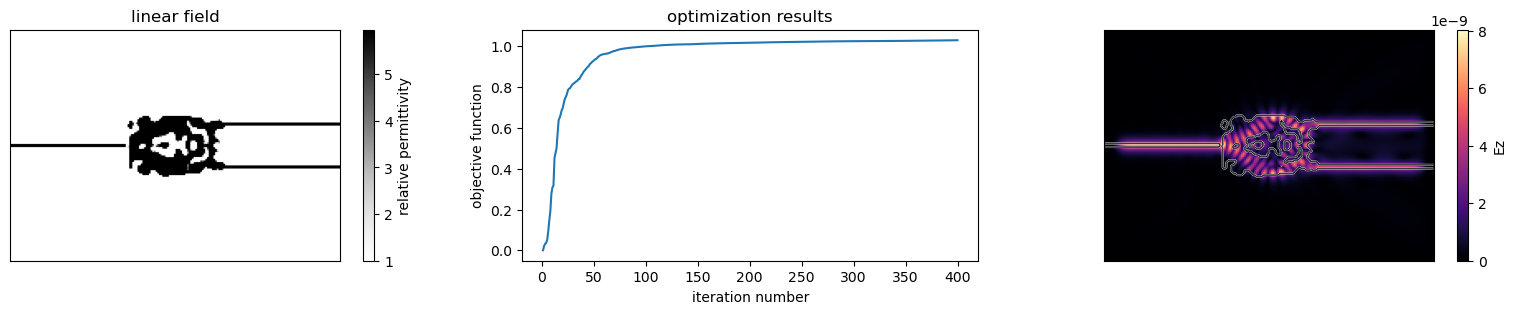

In [30]:
# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

Finally we can measure power transmission of our final `simulation`.

In [31]:
# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

        -> linear transmission (top)        = 49.82 %
        -> linear transmission (bottom)     = 49.52 %


## Conclusion

This was a simple demo of a linear problem.  

For more functionality, please check out our other notebooks!

And if you have a question, feature request, or want to contribute, feel free to reach out on Github.